In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

import cv2
from tqdm import tqdm

from multiprocessing import Pool, cpu_count

from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from keras.callbacks import LambdaCallback, EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('inputs/train_v2.csv')
df_train.head(2)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water


In [3]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}
print(labels)

['slash_burn', 'clear', 'blooming', 'primary', 'cloudy', 'conventional_mine', 'water', 'haze', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'blow_down', 'agriculture', 'road', 'selective_logging']


In [4]:
input_dir = 'inputs'
img_size = 128

X = []
Y = []
for f, tags in tqdm(df_train.values, miniters=1000):
    f_name = '{}.jpg'.format(f)
#     print(os.path.join(input_dir, 'train-jpg', f_name))
    img = cv2.imread(os.path.join(input_dir, 'train-jpg', f_name))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    X.append(cv2.resize(img, (img_size, img_size)))
    Y.append(targets)

X = np.array(X, np.float16) / 255.
Y = np.array(Y, np.uint8)

print(X.shape)
print(Y.shape)

100%|██████████| 40479/40479 [00:33<00:00, 1198.18it/s]


(40479, 128, 128, 3)
(40479, 17)


In [5]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2)

In [6]:
model = Sequential()
model.add(BatchNormalization(input_shape=(img_size,img_size,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(512, (2, 2), padding='same', activation='relu'))
model.add(Conv2D(512, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
# model.summary()

In [7]:
np.random.seed(0)
scores = []
batch_size = 256
epochs = 45

def my_callback_func(batch,logs):
    p_valid = model.predict(X_valid, batch_size=batch_size,verbose=2)
    score = fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2, average='samples')
    scores.append(score)


my_callback = LambdaCallback(on_epoch_end=lambda batch,logs: my_callback_func(batch,logs))
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=0)
# callbacks = [my_callback, early_stop]
callbacks = [my_callback]

history_callback = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=2,
          validation_data=(X_valid, Y_valid), callbacks=callbacks)

print("Max score %f at epoch %d" % (np.max(scores), np.argmax(scores)))

Train on 32383 samples, validate on 8096 samples
Epoch 1/45
71s - loss: 0.3491 - acc: 0.8823 - val_loss: 0.2646 - val_acc: 0.9054
Epoch 2/45
65s - loss: 0.1745 - acc: 0.9314 - val_loss: 0.2583 - val_acc: 0.9055
Epoch 3/45
66s - loss: 0.1611 - acc: 0.9360 - val_loss: 0.2254 - val_acc: 0.9115
Epoch 4/45
66s - loss: 0.1521 - acc: 0.9396 - val_loss: 0.1922 - val_acc: 0.9220
Epoch 5/45
67s - loss: 0.1458 - acc: 0.9423 - val_loss: 0.1563 - val_acc: 0.9382
Epoch 6/45
67s - loss: 0.1409 - acc: 0.9442 - val_loss: 0.1428 - val_acc: 0.9427
Epoch 7/45
67s - loss: 0.1365 - acc: 0.9459 - val_loss: 0.1376 - val_acc: 0.9460
Epoch 8/45
67s - loss: 0.1332 - acc: 0.9472 - val_loss: 0.1246 - val_acc: 0.9502
Epoch 9/45
67s - loss: 0.1284 - acc: 0.9491 - val_loss: 0.1209 - val_acc: 0.9529
Epoch 10/45
67s - loss: 0.1257 - acc: 0.9507 - val_loss: 0.1144 - val_acc: 0.9551
Epoch 11/45
67s - loss: 0.1225 - acc: 0.9520 - val_loss: 0.1151 - val_acc: 0.9549
Epoch 12/45
67s - loss: 0.1197 - acc: 0.9534 - val_loss: 0

Max score 0.912154 at epoch 42


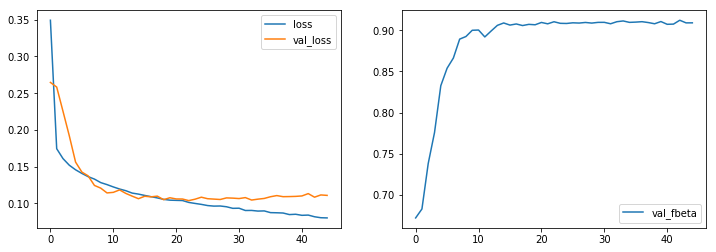

In [8]:
print("Max score %f at epoch %d" % (np.max(scores), np.argmax(scores)))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.legend(labels=['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(scores)
plt.legend(labels=['val_fbeta'])
plt.show()

In [10]:
p_valid = model.predict(X_valid, batch_size=batch_size,verbose=2)
p_valid = (p_valid > 0.2).astype(int)

In [13]:
for i in range(17):
    print("%s: %f" % (inv_label_map[i], fbeta_score(Y_valid[:,i], p_valid[:,i], beta=2)))
print("Average score %f" % fbeta_score(Y_valid, p_valid, beta=2, average='samples'))

slash_burn: 0.000000
clear: 0.972631
blooming: 0.000000
primary: 0.988755
cloudy: 0.844516
conventional_mine: 0.000000
water: 0.775997
haze: 0.710526
cultivation: 0.621099
partly_cloudy: 0.911057
artisinal_mine: 0.594406
habitation: 0.717829
bare_ground: 0.160214
blow_down: 0.000000
agriculture: 0.870763
road: 0.823529
selective_logging: 0.183486
Average score 0.909003


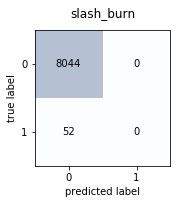

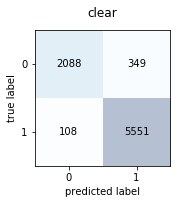

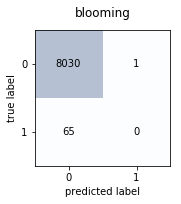

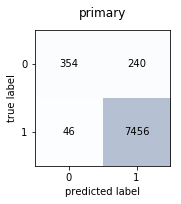

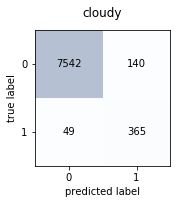

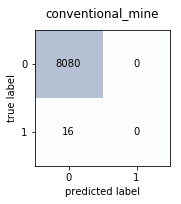

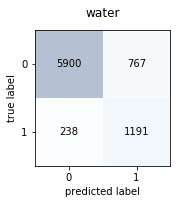

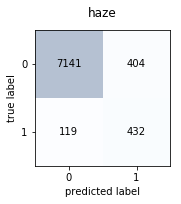

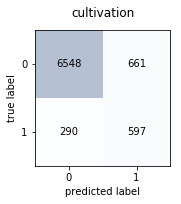

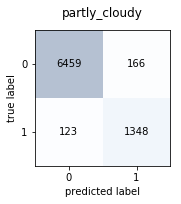

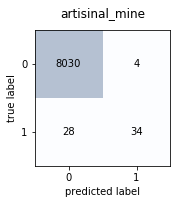

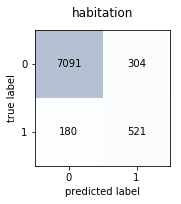

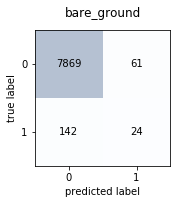

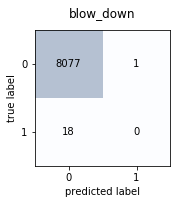

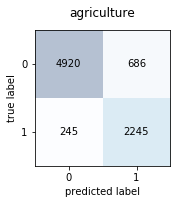

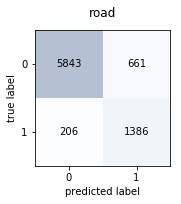

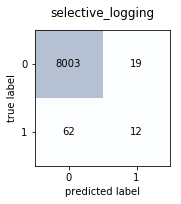

In [12]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
for i in range(17):
    cm = confusion_matrix(y_target=Y_valid[:,i], 
                      y_predicted=p_valid[:,i], binary=False)
    _, ax = plot_confusion_matrix(conf_mat=cm)
    ax.set_title(inv_label_map[i])
plt.show()

In [15]:
def find_ratios(y_true, y_pred):
    scores = np.zeros(17)
    rat = np.zeros(17)
    step = 0.05
    n = int(1/step)
    for j in range(17):
        r = step
        for i in range(n):
            score = fbeta_score(y_true[:,j], (y_pred[:,j] > r).astype(int), beta=2)
            if score > scores[j]:
                scores[j] = score
                rat[j] = r
            r+=step
    rat[rat == 0] = step
    return rat

In [16]:
p_valid = model.predict(X_valid, batch_size=batch_size,verbose=2)
rat = find_ratios(Y_valid, p_valid)
rat

array([ 0.05,  0.05,  0.05,  0.1 ,  0.1 ,  0.05,  0.15,  0.15,  0.1 ,
        0.05,  0.05,  0.15,  0.05,  0.05,  0.1 ,  0.1 ,  0.05])

In [17]:
for i in range(17):
    print("%s: %f" % (inv_label_map[i], fbeta_score(Y_valid[:,i], (p_valid[:,i] > rat[i]).astype(int), beta=2)))
print("Average score %f" % fbeta_score(Y_valid, (p_valid > rat).astype(int), beta=2, average='samples'))

slash_burn: 0.165975
clear: 0.975919
blooming: 0.289474
primary: 0.989356
cloudy: 0.860071
conventional_mine: 0.189873
water: 0.776650
haze: 0.712460
cultivation: 0.661522
partly_cloudy: 0.919181
artisinal_mine: 0.651466
habitation: 0.727200
bare_ground: 0.352113
blow_down: 0.113636
agriculture: 0.883733
road: 0.828422
selective_logging: 0.396635
Average score 0.911070


In [13]:
# import h5py
# model.save('starter1_0.893.h5')